### Installing Packages and Importing Dependencies

In [1]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install opencv-python
# !pip install moviepy

In [2]:
import gym
from math import radians, log10
import numpy as np
from pandas import Series
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import cv2
import time

In [3]:
SEED =42
n_episodes=6000
capture_interval=500
reward_update_interval=500
export_fps=30

In [4]:
env= gym.make('CartPole-v1', render_mode='rgb_array')
env.action_space.seed(SEED)
np.random.seed(SEED)
env.reset(seed=SEED)


(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

In [5]:
graph_x=np.arange(n_episodes)
graph_y=np.zeros(n_episodes)

### Task 1: Development of an RL agent

Reference: https://www.youtube.com/watch?v=yVYBSvbOWu4

Here, we create bins to prepare for discretizer, which converts our continuous variable into discrete. This is required for indexing in our Q table later on.

Note: We will be tweaking tuples bins later on to test which tuple helps achieve the best results for our agent.

In [2]:
n_bins=(12,12,12,12)
lower_bounds=[env.observation_space.low[0], -0.25,
              env.observation_space.low[2], -radians(50)]
upper_bounds=[env.observation_space.high[0], 0.25,
              env.observation_space.high[2], radians(50)]

NameError: name 'env' is not defined

In [7]:
def discretizer(cart_position, cart_velocity, angle, pole_velocity):
    # This automatically determines the bin sizes and locations
    est=KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds])
    return tuple(map(int, est.transform([[cart_position, cart_velocity, angle, pole_velocity]])[0]))

Here, we define our Policy which is how the AI chooses an action each iteration.

It could be either a random action, or to take the best action based on the q table. 

This is a greedy strategy as the chosen action is the best action it knows at the given moment.

In [1]:
def policy(state):
    return np.argmax(Q_table[state])

### Relevant hyperparmeters: exploration rate and learning rate

The learning rate determines how much new information is incorporated into the existing estimates of the Q-values, while the exploration rate determines the probability of taking a random action

As seen below, we allow both our learning rate and exploration rate to decay over time. This helps the algorithm to converge more efficiently to the optimal policy. This is because at the beginning of the training, the agent is exploring the environment and collecting data, and as it learns more about the environment, it can rely more on the Q-values that have already been learned.

If the learning rate is too high, the algorithm may update the Q-values too quickly, which can lead to unstable and inaccurate Q-value estimates. Similarly, if the exploration rate is too high, the agent may continue to take random actions instead of exploiting the existing knowledge, which can slow down the learning process.

Later in the training process, we did trial and error to find the best learning rate and exploration rate to begin with to obtain the best results.

In [9]:
# Modulate the AI's 'curiosity' over time
def exploration_rate(n, exploration_coeff):
    min_rate_er=0.05
    return max(min_rate_er, min(1, 1.0 - log10((n+1)/ exploration_coeff)))

In [10]:
# Modulate the AI's willingness to learn over time
def learning_rate(n, learning_coeff):
    min_rate_lr=0.01
    return max(min_rate_lr, min(1.0, 1.0- log10((n+1)/ learning_coeff)))

### Defining the Q value based on the formula + Create Q table
<div>
<img src="qvalue.png" width="500"/>
</div>

In [11]:
#Q-value maths
def new_Q_value(reward, new_state, discount_factor=1):
    future_optimal_value= np.max(Q_table[new_state])
    learned_value= reward + discount_factor * future_optimal_value
    return learned_value

## Developing RL Agent

In [12]:
# Def the training Function
def run_cartpole(learning_coeff, exploration_coeff, totalTime=0):
    #Q_table=np.zeros(n_bins + (env.action_space.n,))
    for i in range(n_episodes):
        observation, info=env.reset()
        current_state, terminated, truncated = discretizer(*observation), False, False

        # Stat tracking
        total_reward_this_run=0

        # Set up recording every capture interval
        out_video=None
        if i % capture_interval==0:
            height, width, _ =env.render().shape
            out_video= cv2.VideoWriter(
            f"cartpole_iter_{i}.avi",
            cv2.VideoWriter_fourcc(*'XVID'),
            60,
            (width, height))

        while not terminated and not truncated:
            # Start stopwatch for this iteration
            startTime= time.time()

            # Policy action
            action=policy(current_state)
            # Insert random action
            if np.random.random() < exploration_rate(i,exploration_coeff):
                action= env.action_space.sample()

            # Increment environment
            observation, reward, terminated, truncated, info= env.step(action)
            new_state= discretizer(*observation)

            #update the Q table
            lr= learning_rate(i,learning_coeff)
            learnt_value= new_Q_value(reward, new_state)
            old_value= Q_table[current_state][action]
            Q_table[current_state][action]= (1-lr)*old_value + lr*learnt_value

            #update state
            current_state= new_state

            #stats update
            total_reward_this_run +=reward # max reward in this simulation is 1

            # Add training time for this iteration to accumulator
            endTime= time.time()
            totalTime+= endTime- startTime

            #Render environment
            if i % capture_interval ==0:
                out_video.write(env.render())

        #export video
        if i % capture_interval ==0:
            print(f"Writing Video for iteration {i}...")
            out_video.release()

        #debug output
        if i % reward_update_interval ==0:
            print(f"Total reward amassed during run {i}: {total_reward_this_run}")

        #update graph data
        graph_y[i] = total_reward_this_run

    #display graph of reward
    plt.title("Reward over time")
    plt.xlabel="Attempt"
    plt.ylabel="Reward"
    plt.plot(graph_x, graph_y,
            color="blue", linestyle='',
            marker='o', alpha=0.05,
            label="Iter. Reward")
    plt.plot(graph_x, Series(graph_y).rolling(100).mean().tolist(),
            color="red", label="Rolling avg. (100 iter.)")
    plt.show()

    trainM, trainS= map(int, divmod(totalTime, 60))
    print(f"\n Total Training time: {trainM}: {trainS:02}")
    print(f"Run number: {i}, Score: {total_reward_this_run}")

    env.close()

### Varying learning and exploration coefficients 

From here we wanted to find out how both of this parameters would affect the training of the model. Hence, we increase and decrease the learning coefficients simultaneously to get a better undertanding on how it affects the model. In theory, an extremely high learning rate would result in possibly skipping the optimal solution while a low learning rate may require too many interations to converge to the best values. Thus, finding that balance is important.


Writing Video for iteration 0...
Total reward amassed during run 0: 12.0
Writing Video for iteration 10...
Total reward amassed during run 10: 52.0
Writing Video for iteration 20...
Total reward amassed during run 20: 16.0
Writing Video for iteration 30...
Total reward amassed during run 30: 28.0
Writing Video for iteration 40...
Total reward amassed during run 40: 13.0
Writing Video for iteration 50...
Total reward amassed during run 50: 20.0
Writing Video for iteration 60...
Total reward amassed during run 60: 29.0
Writing Video for iteration 70...
Total reward amassed during run 70: 17.0
Writing Video for iteration 80...
Total reward amassed during run 80: 28.0
Writing Video for iteration 90...
Total reward amassed during run 90: 17.0
Writing Video for iteration 100...
Total reward amassed during run 100: 20.0
Writing Video for iteration 110...
Total reward amassed during run 110: 9.0
Writing Video for iteration 120...
Total reward amassed during run 120: 13.0
Writing Video for iter

Writing Video for iteration 1070...
Total reward amassed during run 1070: 91.0
Writing Video for iteration 1080...
Total reward amassed during run 1080: 46.0
Writing Video for iteration 1090...
Total reward amassed during run 1090: 88.0
Writing Video for iteration 1100...
Total reward amassed during run 1100: 99.0
Writing Video for iteration 1110...
Total reward amassed during run 1110: 123.0
Writing Video for iteration 1120...
Total reward amassed during run 1120: 26.0
Writing Video for iteration 1130...
Total reward amassed during run 1130: 39.0
Writing Video for iteration 1140...
Total reward amassed during run 1140: 31.0
Writing Video for iteration 1150...
Total reward amassed during run 1150: 104.0
Writing Video for iteration 1160...
Total reward amassed during run 1160: 63.0
Writing Video for iteration 1170...
Total reward amassed during run 1170: 57.0
Writing Video for iteration 1180...
Total reward amassed during run 1180: 36.0
Writing Video for iteration 1190...
Total reward a

Total reward amassed during run 2110: 17.0
Writing Video for iteration 2120...
Total reward amassed during run 2120: 37.0
Writing Video for iteration 2130...
Total reward amassed during run 2130: 94.0
Writing Video for iteration 2140...
Total reward amassed during run 2140: 154.0
Writing Video for iteration 2150...
Total reward amassed during run 2150: 76.0
Writing Video for iteration 2160...
Total reward amassed during run 2160: 25.0
Writing Video for iteration 2170...
Total reward amassed during run 2170: 106.0
Writing Video for iteration 2180...
Total reward amassed during run 2180: 56.0
Writing Video for iteration 2190...
Total reward amassed during run 2190: 57.0
Writing Video for iteration 2200...
Total reward amassed during run 2200: 16.0
Writing Video for iteration 2210...
Total reward amassed during run 2210: 75.0
Writing Video for iteration 2220...
Total reward amassed during run 2220: 24.0
Writing Video for iteration 2230...
Total reward amassed during run 2230: 157.0
Writin

Writing Video for iteration 3160...
Total reward amassed during run 3160: 38.0
Writing Video for iteration 3170...
Total reward amassed during run 3170: 21.0
Writing Video for iteration 3180...
Total reward amassed during run 3180: 28.0
Writing Video for iteration 3190...
Total reward amassed during run 3190: 25.0
Writing Video for iteration 3200...
Total reward amassed during run 3200: 56.0
Writing Video for iteration 3210...
Total reward amassed during run 3210: 37.0
Writing Video for iteration 3220...
Total reward amassed during run 3220: 56.0
Writing Video for iteration 3230...
Total reward amassed during run 3230: 64.0
Writing Video for iteration 3240...
Total reward amassed during run 3240: 29.0
Writing Video for iteration 3250...
Total reward amassed during run 3250: 64.0
Writing Video for iteration 3260...
Total reward amassed during run 3260: 79.0
Writing Video for iteration 3270...
Total reward amassed during run 3270: 80.0
Writing Video for iteration 3280...
Total reward ama

Writing Video for iteration 4200...
Total reward amassed during run 4200: 47.0
Writing Video for iteration 4210...
Total reward amassed during run 4210: 57.0
Writing Video for iteration 4220...
Total reward amassed during run 4220: 94.0
Writing Video for iteration 4230...
Total reward amassed during run 4230: 41.0
Writing Video for iteration 4240...
Total reward amassed during run 4240: 50.0
Writing Video for iteration 4250...
Total reward amassed during run 4250: 22.0
Writing Video for iteration 4260...
Total reward amassed during run 4260: 63.0
Writing Video for iteration 4270...
Total reward amassed during run 4270: 24.0
Writing Video for iteration 4280...
Total reward amassed during run 4280: 35.0
Writing Video for iteration 4290...
Total reward amassed during run 4290: 31.0
Writing Video for iteration 4300...
Total reward amassed during run 4300: 26.0
Writing Video for iteration 4310...
Total reward amassed during run 4310: 29.0
Writing Video for iteration 4320...
Total reward ama

Writing Video for iteration 5240...
Total reward amassed during run 5240: 71.0
Writing Video for iteration 5250...
Total reward amassed during run 5250: 167.0
Writing Video for iteration 5260...
Total reward amassed during run 5260: 39.0
Writing Video for iteration 5270...
Total reward amassed during run 5270: 57.0
Writing Video for iteration 5280...
Total reward amassed during run 5280: 105.0
Writing Video for iteration 5290...
Total reward amassed during run 5290: 66.0
Writing Video for iteration 5300...
Total reward amassed during run 5300: 12.0
Writing Video for iteration 5310...
Total reward amassed during run 5310: 45.0
Writing Video for iteration 5320...
Total reward amassed during run 5320: 94.0
Writing Video for iteration 5330...
Total reward amassed during run 5330: 26.0
Writing Video for iteration 5340...
Total reward amassed during run 5340: 49.0
Writing Video for iteration 5350...
Total reward amassed during run 5350: 91.0
Writing Video for iteration 5360...
Total reward a

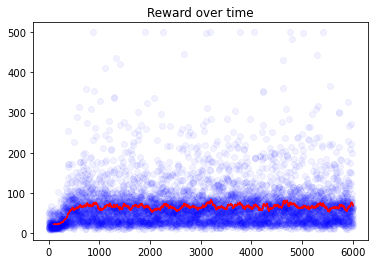


 Total Training time: 2: 22
Run number: 5999, Score: 35.0


In [25]:
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 50
exploration_coeff = 50
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 29.0
Writing Video for iteration 500...
Total reward amassed during run 500: 58.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 44.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 242.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 433.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 500.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 500.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 500.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 500.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 500.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 500.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 500.0


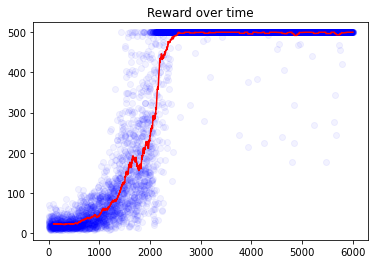


 Total Training time: 12: 49
Run number: 5999, Score: 500.0


In [13]:
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 300
exploration_coeff = 300
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 34.0
Writing Video for iteration 500...
Total reward amassed during run 500: 16.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 38.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 36.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 93.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 55.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 72.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 261.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 500.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 500.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 500.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 500.0


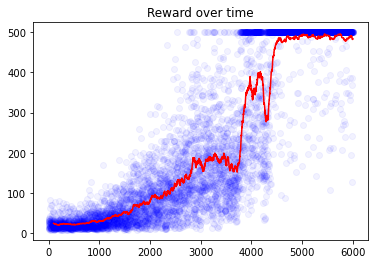


 Total Training time: 8: 24
Run number: 5999, Score: 500.0


In [14]:
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 500
exploration_coeff = 500
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 23.0
Writing Video for iteration 500...
Total reward amassed during run 500: 17.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 48.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 11.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 30.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 12.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 132.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 213.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 118.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 196.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 249.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 345.0


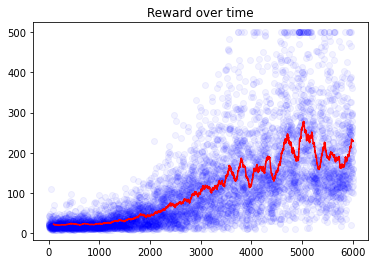


 Total Training time: 4: 12
Run number: 5999, Score: 223.0


In [15]:
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 700
exploration_coeff = 700
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 18.0
Writing Video for iteration 500...
Total reward amassed during run 500: 13.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 16.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 23.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 59.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 55.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 45.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 38.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 162.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 68.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 86.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 154.0


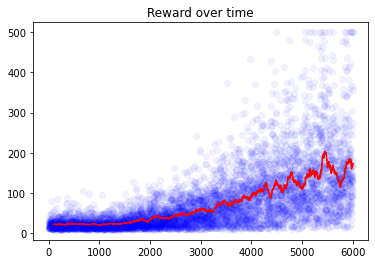


 Total Training time: 2: 47
Run number: 5999, Score: 130.0


In [16]:
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 1000
exploration_coeff = 1000
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 15.0
Writing Video for iteration 500...
Total reward amassed during run 500: 29.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 24.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 15.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 39.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 10.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 120.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 35.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 164.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 245.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 266.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 137.0


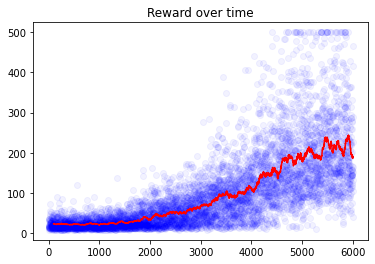


 Total Training time: 3: 43
Run number: 5999, Score: 39.0


In [17]:
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 500
exploration_coeff = 1000
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 23.0
Writing Video for iteration 500...
Total reward amassed during run 500: 55.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 14.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 11.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 69.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 116.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 185.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 189.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 260.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 157.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 500.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 500.0


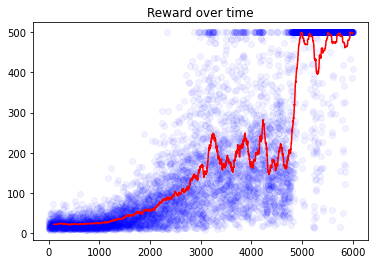


 Total Training time: 7: 00
Run number: 5999, Score: 500.0


In [18]:
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 1000
exploration_coeff = 500
run_cartpole(learning_coeff, exploration_coeff)

### Analysis On varying Learning Coefficients and Exploration Coefficients

From the graphs above, we can conclude that by decreasing the learning coefficient while keeping the exploration coefficient constant did not result in a significant change in the training of the mode. However, the converse did not hold true as it resulted in more significant increases in rewards over more episodes. Ultimately, setting the coefficients too low at 50 as well as too high at 1000 resulted in poor training of models. In the end,  we can identify that the best way to train the model is by setting the learning and exploration coefficients = 300. 

### Analysis On varying Bin Size with coefficients 300

In theory, Binning transforms continuous data into discrete intervals. The mapping provides a high-order ranking of values that can smooth out the relationships between observations. The transformation can be applied to each numeric input variable in the training dataset and then provided as input to a machine learning model to learn a predictive modeling task.

Writing Video for iteration 0...
Total reward amassed during run 0: 11.0
Writing Video for iteration 500...
Total reward amassed during run 500: 13.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 99.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 28.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 137.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 173.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 235.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 308.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 368.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 199.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 251.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 99.0


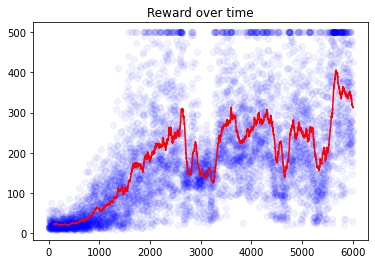


 Total Training time: 7: 23
Run number: 5999, Score: 256.0


In [19]:
n_bins=(8,8,8,8)
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 300
exploration_coeff = 300
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 32.0
Writing Video for iteration 500...
Total reward amassed during run 500: 15.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 25.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 67.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 89.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 500.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 181.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 500.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 427.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 500.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 371.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 500.0


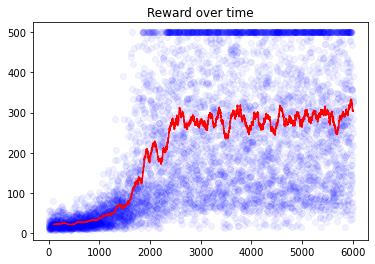


 Total Training time: 7: 45
Run number: 5999, Score: 284.0


In [20]:
n_bins=(20,20,20,20)
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 300
exploration_coeff = 300
run_cartpole(learning_coeff, exploration_coeff)

Writing Video for iteration 0...
Total reward amassed during run 0: 15.0
Writing Video for iteration 500...
Total reward amassed during run 500: 19.0
Writing Video for iteration 1000...
Total reward amassed during run 1000: 12.0
Writing Video for iteration 1500...
Total reward amassed during run 1500: 23.0
Writing Video for iteration 2000...
Total reward amassed during run 2000: 87.0
Writing Video for iteration 2500...
Total reward amassed during run 2500: 411.0
Writing Video for iteration 3000...
Total reward amassed during run 3000: 241.0
Writing Video for iteration 3500...
Total reward amassed during run 3500: 44.0
Writing Video for iteration 4000...
Total reward amassed during run 4000: 500.0
Writing Video for iteration 4500...
Total reward amassed during run 4500: 224.0
Writing Video for iteration 5000...
Total reward amassed during run 5000: 126.0
Writing Video for iteration 5500...
Total reward amassed during run 5500: 173.0


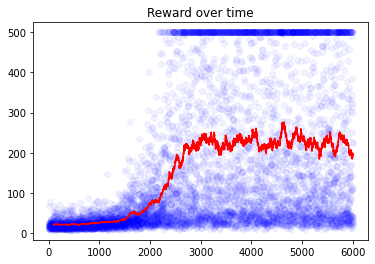


 Total Training time: 6: 01
Run number: 5999, Score: 28.0


In [21]:
n_bins=(12,20,30,40)
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 300
exploration_coeff = 300
run_cartpole(learning_coeff, exploration_coeff)

### Result Analysis 
We can conclude that the best result is when the bins are 12 and both coefficients are 300. We will run the training code again to obtain the optimal Q_Table to be used for the test

Writing Video for iteration 0...
Total reward amassed during run 0: 16.0
Writing Video for iteration 10...
Total reward amassed during run 10: 22.0
Writing Video for iteration 20...
Total reward amassed during run 20: 18.0
Writing Video for iteration 30...
Total reward amassed during run 30: 10.0
Writing Video for iteration 40...
Total reward amassed during run 40: 10.0
Writing Video for iteration 50...
Total reward amassed during run 50: 50.0
Writing Video for iteration 60...
Total reward amassed during run 60: 18.0
Writing Video for iteration 70...
Total reward amassed during run 70: 15.0
Writing Video for iteration 80...
Total reward amassed during run 80: 12.0
Writing Video for iteration 90...
Total reward amassed during run 90: 41.0
Writing Video for iteration 100...
Total reward amassed during run 100: 17.0
Writing Video for iteration 110...
Total reward amassed during run 110: 14.0
Writing Video for iteration 120...
Total reward amassed during run 120: 24.0
Writing Video for ite

Writing Video for iteration 1070...
Total reward amassed during run 1070: 12.0
Writing Video for iteration 1080...
Total reward amassed during run 1080: 68.0
Writing Video for iteration 1090...
Total reward amassed during run 1090: 45.0
Writing Video for iteration 1100...
Total reward amassed during run 1100: 35.0
Writing Video for iteration 1110...
Total reward amassed during run 1110: 48.0
Writing Video for iteration 1120...
Total reward amassed during run 1120: 40.0
Writing Video for iteration 1130...
Total reward amassed during run 1130: 66.0
Writing Video for iteration 1140...
Total reward amassed during run 1140: 94.0
Writing Video for iteration 1150...
Total reward amassed during run 1150: 13.0
Writing Video for iteration 1160...
Total reward amassed during run 1160: 14.0
Writing Video for iteration 1170...
Total reward amassed during run 1170: 65.0
Writing Video for iteration 1180...
Total reward amassed during run 1180: 38.0
Writing Video for iteration 1190...
Total reward ama

Writing Video for iteration 2100...
Total reward amassed during run 2100: 293.0
Writing Video for iteration 2110...
Total reward amassed during run 2110: 158.0
Writing Video for iteration 2120...
Total reward amassed during run 2120: 355.0
Writing Video for iteration 2130...
Total reward amassed during run 2130: 500.0
Writing Video for iteration 2140...
Total reward amassed during run 2140: 216.0
Writing Video for iteration 2150...
Total reward amassed during run 2150: 500.0
Writing Video for iteration 2160...
Total reward amassed during run 2160: 500.0
Writing Video for iteration 2170...
Total reward amassed during run 2170: 500.0
Writing Video for iteration 2180...
Total reward amassed during run 2180: 166.0
Writing Video for iteration 2190...
Total reward amassed during run 2190: 500.0
Writing Video for iteration 2200...
Total reward amassed during run 2200: 500.0
Writing Video for iteration 2210...
Total reward amassed during run 2210: 460.0
Writing Video for iteration 2220...
Tota

Writing Video for iteration 3130...
Total reward amassed during run 3130: 500.0
Writing Video for iteration 3140...
Total reward amassed during run 3140: 500.0
Writing Video for iteration 3150...
Total reward amassed during run 3150: 500.0
Writing Video for iteration 3160...
Total reward amassed during run 3160: 500.0
Writing Video for iteration 3170...
Total reward amassed during run 3170: 500.0
Writing Video for iteration 3180...
Total reward amassed during run 3180: 500.0
Writing Video for iteration 3190...
Total reward amassed during run 3190: 500.0
Writing Video for iteration 3200...
Total reward amassed during run 3200: 500.0
Writing Video for iteration 3210...
Total reward amassed during run 3210: 500.0
Writing Video for iteration 3220...
Total reward amassed during run 3220: 500.0
Writing Video for iteration 3230...
Total reward amassed during run 3230: 500.0
Writing Video for iteration 3240...
Total reward amassed during run 3240: 500.0
Writing Video for iteration 3250...
Tota

Writing Video for iteration 4160...
Total reward amassed during run 4160: 500.0
Writing Video for iteration 4170...
Total reward amassed during run 4170: 500.0
Writing Video for iteration 4180...
Total reward amassed during run 4180: 500.0
Writing Video for iteration 4190...
Total reward amassed during run 4190: 500.0
Writing Video for iteration 4200...
Total reward amassed during run 4200: 500.0
Writing Video for iteration 4210...
Total reward amassed during run 4210: 500.0
Writing Video for iteration 4220...
Total reward amassed during run 4220: 500.0
Writing Video for iteration 4230...
Total reward amassed during run 4230: 500.0
Writing Video for iteration 4240...
Total reward amassed during run 4240: 500.0
Writing Video for iteration 4250...
Total reward amassed during run 4250: 500.0
Writing Video for iteration 4260...
Total reward amassed during run 4260: 500.0
Writing Video for iteration 4270...
Total reward amassed during run 4270: 500.0
Writing Video for iteration 4280...
Tota

Writing Video for iteration 5190...
Total reward amassed during run 5190: 500.0
Writing Video for iteration 5200...
Total reward amassed during run 5200: 500.0
Writing Video for iteration 5210...
Total reward amassed during run 5210: 500.0
Writing Video for iteration 5220...
Total reward amassed during run 5220: 500.0
Writing Video for iteration 5230...
Total reward amassed during run 5230: 500.0
Writing Video for iteration 5240...
Total reward amassed during run 5240: 338.0
Writing Video for iteration 5250...
Total reward amassed during run 5250: 500.0
Writing Video for iteration 5260...
Total reward amassed during run 5260: 500.0
Writing Video for iteration 5270...
Total reward amassed during run 5270: 500.0
Writing Video for iteration 5280...
Total reward amassed during run 5280: 500.0
Writing Video for iteration 5290...
Total reward amassed during run 5290: 500.0
Writing Video for iteration 5300...
Total reward amassed during run 5300: 500.0
Writing Video for iteration 5310...
Tota

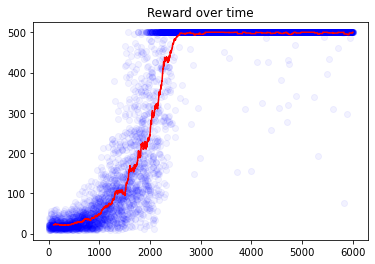


 Total Training time: 13: 37
Run number: 5999, Score: 500.0


In [27]:
n_bins=(12,12,12,12)
Q_table=np.zeros(n_bins + (env.action_space.n,))
learning_coeff= 300
exploration_coeff = 300
run_cartpole(learning_coeff, exploration_coeff)

## Task 1: Demonstrating correctness of Training Agent


In [29]:
observation, info=env.reset()
current_state, terminated, truncated = discretizer(*observation), False, False
action=policy(current_state)
print("Observation: ", observation)
print("Chosen Action: ", action)

Observation:  [-0.00610255 -0.04835328  0.02032213 -0.03564339]
Chosen Action:  1


## Task 2: Demonstrating effectiveness of Agent

Moviepy - Building video C:\Users\darre\Downloads\video\rl-video-episode-1.mp4.
Moviepy - Writing video C:\Users\darre\Downloads\video\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\darre\Downloads\video\rl-video-episode-1.mp4
Run number: 0, Score: 500.0
Moviepy - Building video C:\Users\darre\Downloads\video\rl-video-episode-8.mp4.
Moviepy - Writing video C:\Users\darre\Downloads\video\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\darre\Downloads\video\rl-video-episode-8.mp4
Run number: 10, Score: 500.0
Run number: 20, Score: 500.0
Moviepy - Building video C:\Users\darre\Downloads\video\rl-video-episode-27.mp4.
Moviepy - Writing video C:\Users\darre\Downloads\video\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\darre\Downloads\video\rl-video-episode-27.mp4
Run number: 30, Score: 500.0
Run number: 40, Score: 500.0
Run number: 50, Score: 500.0
Run number: 60, Score: 500.0
Moviepy - Building video C:\Users\darre\Downloads\video\rl-video-episode-64.mp4.
Moviepy - Writing video C:\Users\darre\Downloads\video\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\darre\Downloads\video\rl-video-episode-64.mp4
Run number: 70, Score: 500.0
Run number: 80, Score: 500.0
Run number: 90, Score: 500.0


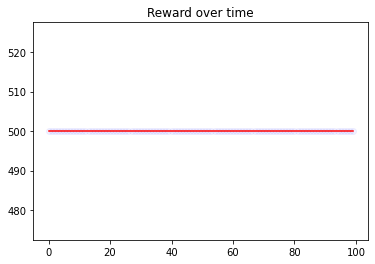

Average accumulative reward:  500.0
Is my agent good enough?  True


In [31]:
# Test loop
import statistics
RewardsList=[]
reward_update_interval=10
capture_interval=10
i=0
totalTime = 0
# Graph parameters
graph_Test_x=np.arange(100)
graph_Test_y=np.zeros(100)

for i in range(100):
    observation, info=env.reset()
    current_state, terminated, truncated = discretizer(*observation), False, False
    
    # Stat tracking
    total_reward_this_run=0
        
    while not terminated and not truncated:
        # Start stopwatch for this iteration
        startTime= time.time()
        
        # Policy action
        action=policy(current_state)
        
        # Took out random action (just let the agent follow the Q Table)
        
        # Increment environment
        observation, reward, terminated, truncated, info= env.step(action)
        new_state= discretizer(*observation)
        
        # Took out updating of Q Table
        
        #update state
        current_state= new_state
        
        #stats update
        total_reward_this_run +=reward # max reward in this simulation is 1
        
        # Add training time for this iteration to accumulator
        endTime= time.time()
        totalTime+= endTime- startTime
        
    
    #update graph data
    graph_Test_y[i] = total_reward_this_run
    
    if i%capture_interval==0:
        print(f"Run number: {i}, Score: {total_reward_this_run}")
        
    RewardsList.append(total_reward_this_run)
    
    
#display graph of reward
plt.title("Reward over time")
plt.xlabel="Attempt"
plt.ylabel="Reward"
plt.plot(graph_Test_x, graph_Test_y,
        color="blue", linestyle='',marker='o',
         alpha=0.05,
        label="Iter. Reward")
plt.plot(graph_Test_x, Series(graph_Test_y).rolling(1).mean().tolist(),
        color="red", label="Rolling avg. (1 iter.)")
plt.show()

print('Average accumulative reward: ',statistics.mean(RewardsList))
print('Is my agent good enough? ', statistics.mean(RewardsList)>195)

env.close()

## Task 3: Rendering one episode played by the Agent

In [30]:
from gym.wrappers import RecordVideo
import io
import glob
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./video")
reward_update_interval=10
capture_interval=10
i=0


observation, info=env.reset()
current_state, terminated, truncated = discretizer(*observation), False, False

# Stat tracking
total_reward_this_run=0


while not terminated and not truncated:
    #env.render()
    # Start stopwatch for this iteration
    startTime= time.time()

    # Policy action
    action=policy(current_state)
    
    # Took out random action (just let the agent follow the Q Table)

    # Increment environment
    observation, reward, terminated, truncated, info= env.step(action)
    new_state= discretizer(*observation)

    # Took out updating of Q Table

    #update state
    current_state= new_state

    #stats update
    total_reward_this_run +=reward # max reward in this simulation is 1

    # Add training time for this iteration to accumulator
    endTime= time.time()
    totalTime+= endTime- startTime


#debug output
#if i % reward_update_interval ==0:
#    print(f"Total reward amassed during run {i}: {total_reward_this_run}")



print(f"Run number: {1}, Score: {total_reward_this_run}")

trainM, trainS= map(int, divmod(totalTime, 60))
print(f"\n Total Training time: {trainM}: {trainS:02}")


env.close()
show_video()

C:\Users\darre\anaconda3\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\darre\Downloads\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video C:\Users\darre\Downloads\video\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\darre\Downloads\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\darre\Downloads\video\rl-video-episode-0.mp4
Run number: 1, Score: 500.0

 Total Training time: 0: 18
